In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras

In [2]:

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**DATA PREPROCESSING**

In [3]:
import pathlib #library to match dataset path
data_dir = "./images"  # dataset location
data_dir = pathlib.Path(data_dir)  #makes folder loaction of dataset into a path

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,             #dataset name
                                                       shuffle=True,
                                                       validation_split=0.25,
                                                       subset="training",    #part for training
                                                       seed=123,             #Optional random seed for shuffling and transformations.
                                                       image_size=(160,160), #resize images
                                                       batch_size=32)        #Size of the batches of data. Default: 32. If None, the data will not be batched (the dataset will yield individual samples).

valid_ds= tf.keras.utils.image_dataset_from_directory(data_dir,
                                                      shuffle=True,
                                                       validation_split=0.25,
                                                       subset="validation",
                                                       seed=123,
                                                       image_size=(160,160),
                                                       batch_size=32)


Found 203 files belonging to 2 classes.
Using 153 files for training.
Found 203 files belonging to 2 classes.
Using 50 files for validation.


In [4]:
classes  = train_ds.class_names
classes

['phones', 'sunglasses']

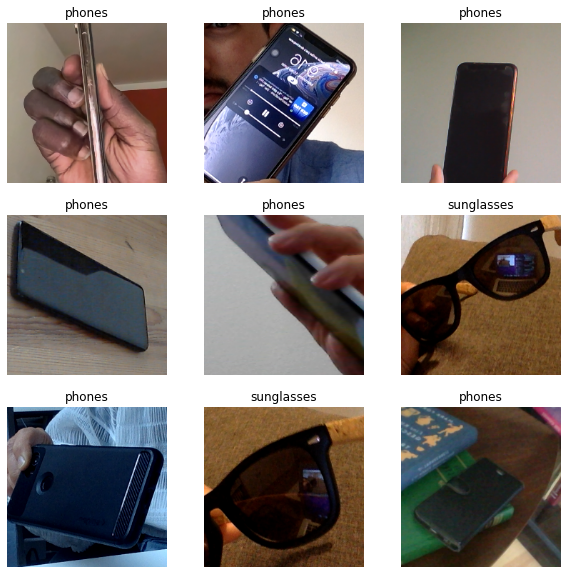

In [5]:
#showing the first 9 images and labels of train.ds
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):             #taking the first batch in train_ds
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)                   #(rows,columns, i + next)
    plt.imshow(images[i].numpy().astype("uint8"))   
    plt.title(classes[labels[i]])
    plt.axis("off")

In [6]:
#creating a test dataset set from the validation dataset since we none
val_batches = tf.data.experimental.cardinality(valid_ds).numpy()   #cadinality simply shows the batches in valid_ds
test_ds = valid_ds.take(val_batches // 2)                          #taking the last batch 
valid_ds = valid_ds.skip(val_batches // 2)                         #skipping the last batch


In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_ds)) #batch size of valid_ds
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))        #batch size of test_ds

Number of validation batches: 1
Number of test batches: 1


**Configure the dataset for performance**  #OPTIONAL

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE #instance of a class to transform data

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

**Data augmentation**

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [9]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
    ])

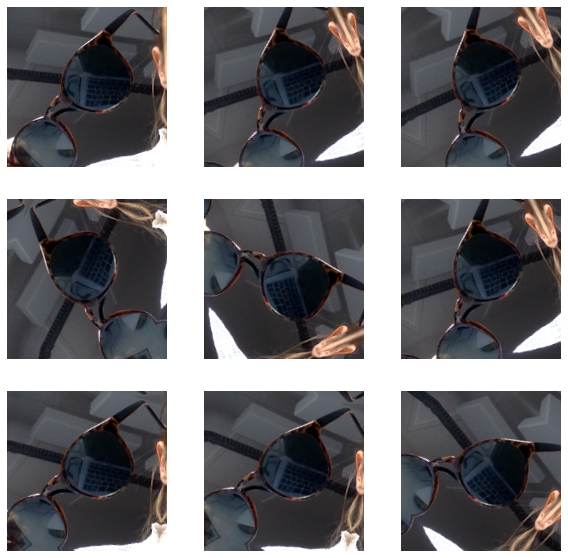

In [10]:
#applying augmentation on the first image to see the result
with tf.device('/cpu:0'):
    for image, _ in train_ds.take(1):
        plt.figure(figsize=(10, 10))
        first_image = image[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
            plt.imshow(augmented_image[0] / 255)
            plt.axis('off')

**Rescale pixel values**

Using tf.keras.applications.MobileNetV2 as the base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in the images are in [0, 255]. we use the preprocessing method included with the model to rescale our images.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Creating a base model from the pretrained convnets and Extracting features**

In [12]:
# Create the base model from the pre-trained model MobileNet V2

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights= "imagenet", 
    #alpha= 0.35,         # specific parameter of this model,  decreases number of filters and weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers 
    input_shape=(160, 160, 3)
)

# freeze it!
base_model.trainable = False   #It is important to freeze the convolutional 
                               #base before you compile and train the model. 
                               #Freezing (by setting layer.trainable = False) prevents the weights in a given layer 
                               #from being updated during training. MobileNet V2 has many layers, 
                               #so setting the entire model's trainable flag to False will freeze all of them.

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1280)


In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
#x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [19]:
len(model.trainable_variables)

2

**TRAIN THE MODEL**

In [20]:
#with tf.device('/GPU:0')
initial_epochs = 30

loss0, accuracy0 = model.evaluate(valid_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.5669 - accuracy: 0.5556


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.57
initial accuracy: 0.56


In [22]:
with tf.device('/GPU:0'):
    history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=valid_ds)

Epoch 1/30
5/5 [==============================] - 3s 208ms/step - loss: 0.8552 - accuracy: 0.5425 - val_loss: 0.4124 - val_accuracy: 0.8333
Epoch 2/30
5/5 [==============================] - 1s 121ms/step - loss: 0.8360 - accuracy: 0.5817 - val_loss: 0.4507 - val_accuracy: 0.7778
Epoch 3/30
5/5 [==============================] - 1s 127ms/step - loss: 0.7658 - accuracy: 0.6078 - val_loss: 0.3532 - val_accuracy: 0.8889
Epoch 4/30
5/5 [==============================] - 1s 129ms/step - loss: 0.7964 - accuracy: 0.5948 - val_loss: 0.6268 - val_accuracy: 0.7222
Epoch 5/30
5/5 [==============================] - 1s 126ms/step - loss: 0.7671 - accuracy: 0.6536 - val_loss: 0.4720 - val_accuracy: 0.7778
Epoch 6/30
5/5 [==============================] - 1s 122ms/step - loss: 0.6539 - accuracy: 0.6536 - val_loss: 0.3469 - val_accuracy: 0.8889
Epoch 7/30
5/5 [==============================] - 1s 129ms/step - loss: 0.7626 - accuracy: 0.6536 - val_loss: 0.6769 - val_accuracy: 0.5000
Epoch 8/30
5/5 [====

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

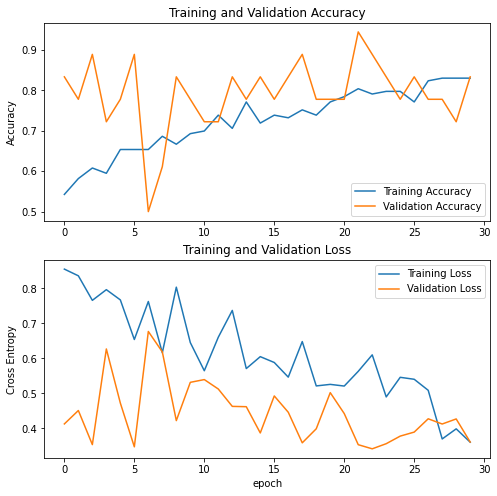

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

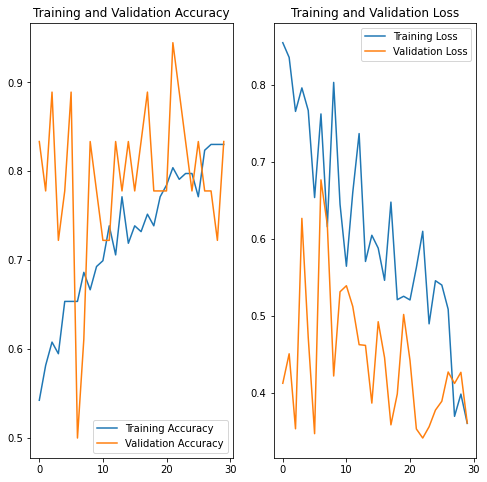

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### Fine tuning
#Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  155


### 2nd compile model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

### 2nd train model

In [28]:
 with tf.device('/GPU:0'):
        fine_tune_epochs = 30
        total_epochs =  initial_epochs + fine_tune_epochs

        history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 30/60
5/5 [==============================] - 5s 416ms/step - loss: 0.3894 - accuracy: 0.8497 - val_loss: 0.2936 - val_accuracy: 0.7778
Epoch 31/60
5/5 [==============================] - 1s 142ms/step - loss: 0.2725 - accuracy: 0.9085 - val_loss: 0.2142 - val_accuracy: 0.8889
Epoch 32/60
5/5 [==============================] - 1s 133ms/step - loss: 0.2490 - accuracy: 0.9216 - val_loss: 0.1535 - val_accuracy: 0.9444
Epoch 33/60
5/5 [==============================] - 1s 134ms/step - loss: 0.2601 - accuracy: 0.9477 - val_loss: 0.2140 - val_accuracy: 0.8333
Epoch 34/60
5/5 [==============================] - 1s 137ms/step - loss: 0.2520 - accuracy: 0.9281 - val_loss: 0.1722 - val_accuracy: 0.8889
Epoch 35/60
5/5 [==============================] - 1s 139ms/step - loss: 0.1680 - accuracy: 0.9542 - val_loss: 0.2155 - val_accuracy: 1.0000
Epoch 36/60
5/5 [==============================] - 1s 138ms/step - loss: 0.1506 - accuracy: 0.9608 - val_loss: 0.1819 - val_accuracy: 0.9444
Epoch 37/60
5

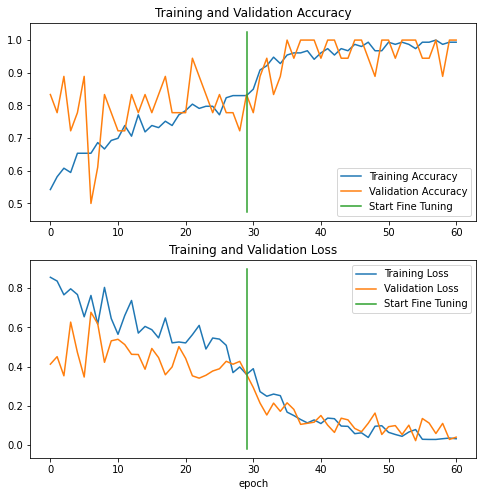

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.9, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 0.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [30]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 190ms/step - loss: 0.0425 - accuracy: 1.0000
Test accuracy : 1.0


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0]
Labels:
 [0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0]


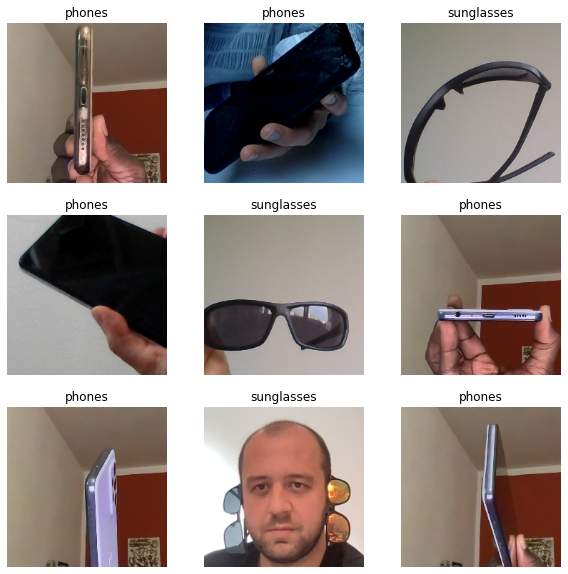

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(classes[predictions[i]])
    plt.axis("off")

### Save model and architecture to single file

In [32]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk
